## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [220]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp

import sklearn as skl
#######################
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from xgboost import XGBClassifier
import time, pickle, decimal
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt import space_eval

#######################
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import SMOTE

In [3]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data_new = train_data
train_data_new.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [4]:
train_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [5]:
train_data_new.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [6]:
train_data_new.groupby(['Promotion', 'purchase']).count()

ID     V1     V2     V3     V4     V5     V6     V7
Promotion purchase                                                        
No        0         41851  41851  41851  41851  41851  41851  41851  41851
          1           319    319    319    319    319    319    319    319
Yes       0         41643  41643  41643  41643  41643  41643  41643  41643
          1           721    721    721    721    721    721    721    721

In [7]:
new_promotion_col = pd.get_dummies(train_data_new['Promotion'], dummy_na=False, drop_first=True)

In [8]:
new_promotion_col.head()

,Yes
0,0
1,0
2,0
3,0
4,1


In [9]:
train_data_new = pd.concat([train_data_new, new_promotion_col], axis=1)

In [10]:
train_data_new.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,Yes
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,1


In [11]:
train_data_new.drop(columns='Promotion', inplace=True)

In [12]:
train_data_new.head()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7,Yes
0,1,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,0,2,30.431659,0.133583,1,1,4,2,0
3,5,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,0,3,28.044332,-0.385883,1,1,2,2,1


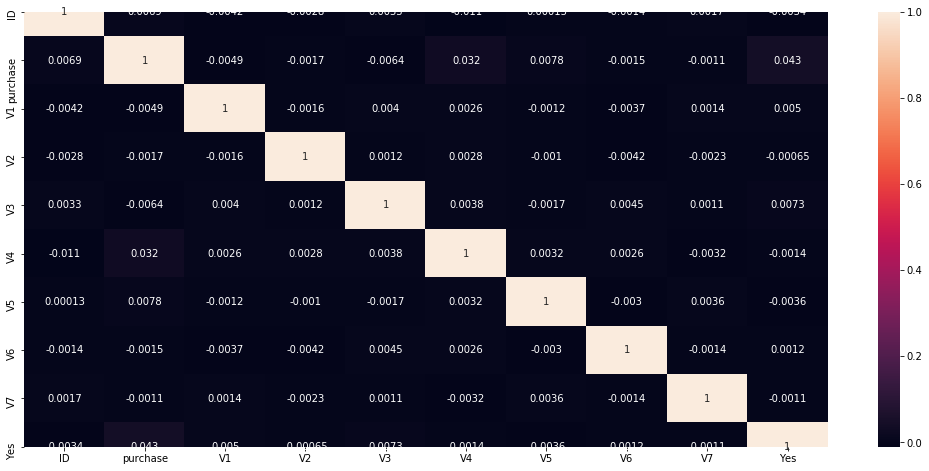

In [13]:
plt.figure(figsize=(18,8))
sns.heatmap(train_data_new.corr(), annot=True)

In [14]:
train_data_new.columns

Index(['ID', 'purchase', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'Yes'], dtype='object')

In [25]:
X = train_data_new[['Yes', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
#X = train_data_new[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y = train_data_new['purchase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)


In [26]:
logmodel = LogisticRegression()

In [27]:
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
prediction = logmodel.predict(X_test)

In [29]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     33387
           1       0.00      0.00      0.00       427

    accuracy                           0.99     33814
   macro avg       0.49      0.50      0.50     33814
weighted avg       0.97      0.99      0.98     33814



/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print(confusion_matrix(y_test,prediction))

[[33387     0]
 [  427     0]]


In [31]:
train_data_new[(train_data_new['purchase']==1)].head()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7,Yes
107,162,1,1,33.030562,-0.732194,2,1,1,1,1
328,503,1,3,31.760033,1.518828,2,1,2,2,1
352,534,1,2,17.512709,1.259095,2,3,4,2,1
383,580,1,1,31.043735,-1.338239,2,1,2,1,1
423,639,1,1,34.901993,-0.905350,2,3,2,2,0


In [32]:
train_data_purchased = train_data_new[(train_data_new['purchase']==1)]

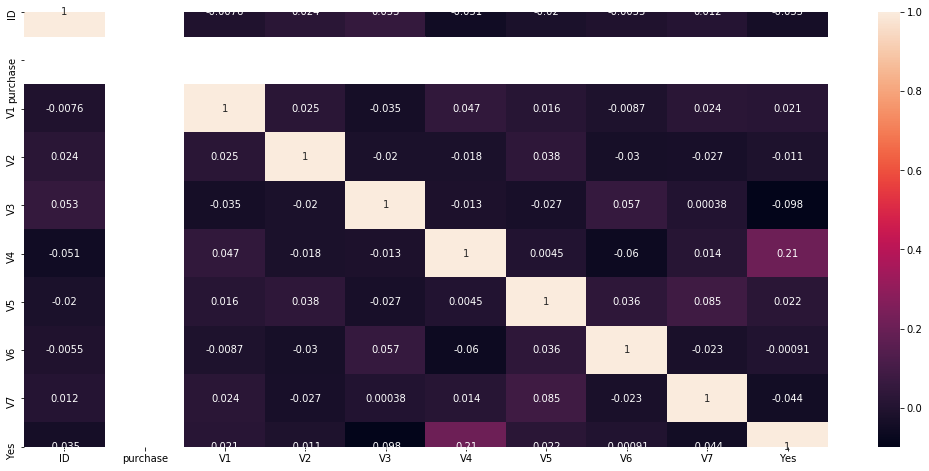

In [33]:
plt.figure(figsize=(18,8))
sns.heatmap(train_data_purchased.corr(), annot=True)

In [44]:
#!pip install -U imbalanced-learn
#!pip install Tensorflow
#!pip install imblearn
#!pip install imbalanced-learn
#!pip install xgboost
#!pip install scikit-learn
#!pip install scikit-learn==0.22.1 
##################################################
#from collections import Counter
#from sklearn.datasets import make_classification
#from imblearn.over_sampling import SMOTE
#import imblearn as imb
#import imblearn.over_sampling.SMOTE as smt
##################################################

In [39]:

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
#oversampled_trainX, oversampled_trainY = sm.fit_sample(train_data_new.drop('Class', axis=1), credit_df['Class'])
#oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
#oversampled_train.columns = normalized_df.columns

In [40]:
sm = SMOTE(random_state=42, ratio=1.0)

In [41]:
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravell()) 

/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [42]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

After OverSampling, the shape of train_X: (100214, 8)
After OverSampling, the shape of train_y: (100214,) 

After OverSampling, counts of label '1': 50107
After OverSampling, counts of label '0': 50107


In [163]:
lr1 = LogisticRegression() 
lr1.fit(X_train_res, y_train_res.ravel()) 
predictions = lr1.predict(X_test)
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

       False       0.99      0.90      0.94     16699
        True       0.01      0.09      0.02       208

    accuracy                           0.89     16907
   macro avg       0.50      0.50      0.48     16907
weighted avg       0.98      0.89      0.93     16907



In [ ]:
#######################################

In [164]:
train_data_1 = train_data.copy()


In [165]:
train_data_1["response"] = train_data_1["purchase"] == 1


In [166]:
train_data_1["response"].unique()

array([False,  True])

In [167]:
features = ["V"+str(x) for x in range(1,8)] + ["Promotion"]

In [168]:
X = pd.get_dummies(train_data_1[features])

In [169]:
X.shape

(84534, 9)

In [170]:
features=X.columns

In [171]:
Y = train_data_1["response"]

In [172]:
Y.value_counts()

False    83494
True      1040
Name: response, dtype: int64

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [174]:
sm = SMOTE(random_state=42, ratio=1.0)

In [175]:
X_balanced_train, Y_balanced_train = sm.fit_resample(X_train, y_train)

/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [176]:
X_balanced_train = pd.DataFrame(X_balanced_train, columns=features)

In [177]:
X_balanced_train.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'Promotion_No',
       'Promotion_Yes'],
      dtype='object')

In [178]:
Y_balanced_train = pd.Series(Y_balanced_train)

In [179]:

cv = GridSearchCV(estimator=XGBClassifier(), param_grid={
        "max_depth": range(5,8,1),
        "min_child_weight": [5, 10, 20, 50],
        "gamma": [0, 0.1, 0.2],
        "random_state": [42],
        "n_estimators": [1000]
        },
        scoring="f1",
         cv=3)


start_time = time.time()
fit_params= {
            "eval_set": [(X_test, y_test)],
            "eval_metric": "logloss",
            "early_stopping_rounds":20,
            "verbose": 0
        }
cv.fit(X_balanced_train, Y_balanced_train, **fit_params)
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))

Elapsed computation time: 128.589 mins


In [192]:
cv.best_params_

{'gamma': 0.1,
 'max_depth': 6,
 'min_child_weight': 10,
 'n_estimators': 1000,
 'random_state': 42}

In [193]:
# This will help us deciding number of estimators
xgb = XGBClassifier(n_estimators=1000)
best_params_xgb = cv.best_params_
xgb.set_params(**best_params_xgb)
xgb.fit(X=X_balanced_train, y=Y_balanced_train.values.ravel(), eval_set=[(X_test, y_test)], 
        eval_metric="logloss", early_stopping_rounds=10, verbose=10)

[0]	validation_0-logloss:0.651736
Will train until validation_0-logloss hasn't improved in 10 rounds.
[10]	validation_0-logloss:0.467548
[20]	validation_0-logloss:0.361545
[30]	validation_0-logloss:0.298454
[40]	validation_0-logloss:0.25701
[50]	validation_0-logloss:0.230457
[60]	validation_0-logloss:0.211893
[70]	validation_0-logloss:0.19325
[80]	validation_0-logloss:0.179203
[90]	validation_0-logloss:0.163888
[100]	validation_0-logloss:0.152161
[110]	validation_0-logloss:0.139522
[120]	validation_0-logloss:0.132642
[130]	validation_0-logloss:0.124634
[140]	validation_0-logloss:0.117031
[150]	validation_0-logloss:0.110356
[160]	validation_0-logloss:0.104467
[170]	validation_0-logloss:0.100311
[180]	validation_0-logloss:0.094953
[190]	validation_0-logloss:0.090794
[200]	validation_0-logloss:0.088276
[210]	validation_0-logloss:0.085795
[220]	validation_0-logloss:0.084368
[230]	validation_0-logloss:0.082699
[240]	validation_0-logloss:0.080333
[250]	validation_0-logloss:0.079036
[260]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [194]:
optimal_n_estimators = xgb.best_ntree_limit

In [195]:
X_balanced, Y_balanced = sm.fit_sample(X,Y)
X_balanced = pd.DataFrame(X_balanced, columns=features)
Y_balanced = pd.Series(Y_balanced)

/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [196]:
xgb = XGBClassifier(max_depth=best_params_xgb["max_depth"],
                    gamma=best_params_xgb["gamma"],
                    min_child_weight=best_params_xgb["min_child_weight"],
                    n_estimators=optimal_n_estimators,
                    random_state=42)
xgb.fit(X_balanced, Y_balanced)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=10, missing=None, n_estimators=528, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [197]:
#pickle.dump(xgb, open(data_dir + 'xgb_best_approach_2.pkl', 'wb'))
pickle.dump(xgb, open('xgb_best_approach_2.pkl', 'wb'))

In [198]:
#model = pickle.load(open(data_dir + "xgb_best_approach_2.pkl", 'rb'))
model = pickle.load(open("xgb_best_approach_2.pkl", 'rb'))

In [199]:
def evaluate(X, Y, diff_threshold, after_promotion_purchase_prob_threshold):
    def score(df, promo_pred_col = 'Promotion'):
        n_treat       = df.loc[df[promo_pred_col] == 'Yes',:].shape[0]
        n_control     = df.loc[df[promo_pred_col] == 'No',:].shape[0]
        n_treat_purch = df.loc[df[promo_pred_col] == 'Yes', 'purchase'].sum()
        n_ctrl_purch  = df.loc[df[promo_pred_col] == 'No', 'purchase'].sum()
        nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
        return nir
    
    nir_scores = []
    kf = KFold(n_splits=10, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_valid = X.loc[train_index], X.loc[test_index]
        Y_train, Y_valid = Y.loc[train_index], Y.loc[test_index]
        
        # As we have already trained the hyper parameters for XGBoost, we need not train it again here
        # we can use the trained model, to calculate score for given threshold value
        model = pickle.load(open("xgb_best_approach_2.pkl", 'rb'))
        
        X_valid_with_promo = X_valid.copy()
        # predict probability of purchase with promotion
        X_valid_with_promo["Promotion_Yes"] = 1
        X_valid_with_promo["Promotion_No"] = 0
        probs_with_promotion = model.predict_proba(X_valid_with_promo)[:, 1]

        # predict probability of purchase without promotion
        X_valid_with_promo["Promotion_Yes"] = 0
        X_valid_with_promo["Promotion_No"] = 1

        probs_without_promotion = model.predict_proba(X_valid_with_promo)[:, 1]

        # calculate the difference as diff
        diff = probs_with_promotion - probs_without_promotion

        # if diff is above threshold choose to promote else don't
        promos = (probs_with_promotion > after_promotion_purchase_prob_threshold) & (diff > diff_threshold)
        val_data = X_valid.copy()
        val_data["Promotion"] = "No"
        val_data.loc[val_data["Promotion_Yes"] == 1, "Promotion"] = "Yes"
        val_data["purchase"] = Y_valid.copy()
        score_df = val_data.iloc[np.where(promos)]
        nir = score(score_df)
        nir_scores.append(nir)
    return np.asscalar(np.mean(nir_scores))

In [200]:
(X_valid.index == y_valid.index).all()

True

In [201]:
def float_range(start, stop, step):
    start = decimal.Decimal(start)
    stop = decimal.Decimal(stop)
    step = decimal.Decimal(step)
    while (start < stop):
        yield float(start)
        start += step
        
evaluated_point_scores = {}

def objective_threshold(params):
    if (str(params) in evaluated_point_scores):
        return evaluated_point_scores[str(params)]
    else:
        print(params)
        diff_threshold = params["diff_threshold"]
        after_promotion_purchase_prob_threshold = params["after_promotion_purchase_prob_threshold"]
        nir_score = evaluate(X=X_test, Y=y_test, 
                             diff_threshold=diff_threshold, 
                             after_promotion_purchase_prob_threshold=after_promotion_purchase_prob_threshold)
        print("nir: " + str(nir_score))        
        evaluated_point_scores[str(params)] = -nir_score
        return -nir_score

param_space = {
    "diff_threshold": hp.choice("diff_threshold", list(float_range("0.02", "0.04", "0.001"))),
    "after_promotion_purchase_prob_threshold": hp.choice("after_promotion_purchase_prob_threshold", list(float_range("0.0", "1.0", "0.1")))
}

start_time = time.time()
best_params_threshold = space_eval(
    param_space, 
    fmin(objective_threshold, 
         param_space, 
         algo=hyperopt.tpe.suggest,
         max_evals=200))
print(best_params_threshold)
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
best_diff_threshold = best_params_threshold["diff_threshold"]
best_after_promotion_purchase_prob_threshold = best_params_threshold["after_promotion_purchase_prob_threshold"]

{'after_promotion_purchase_prob_threshold': 0.1, 'diff_threshold': 0.02}
  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning

/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]

/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/st

nir: 13.01                                             
{'after_promotion_purchase_prob_threshold': 0.5, 'diff_threshold': 0.032}
  0%|          | 1/200 [00:00<03:02,  1.09trial/s, best loss: -13.01]

/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead



nir: 0.985                                                           
{'after_promotion_purchase_prob_threshold': 0.8, 'diff_threshold': 0.033}
nir: 0.0                                                             
{'after_promotion_purchase_prob_threshold': 0.2, 'diff_threshold': 0.024}
nir: 2.91                                                            
{'after_promotion_purchase_prob_threshold': 0.0, 'diff_threshold': 0.028}
nir: 14.184999999999999                                              
{'after_promotion_purchase_prob_threshold': 0.4, 'diff_threshold': 0.033}         
nir: 1.97                                                                         
{'after_promotion_purchase_prob_threshold': 0.0, 'diff_threshold': 0.029}         
nir: 13.409999999999997                                                           
{'after_promotion_purchase_prob_threshold': 0.8, 'diff_threshold': 0.039}         
nir: 0.0                                                                          


nir: 13.01                                                              
{'after_promotion_purchase_prob_threshold': 0.7, 'diff_threshold': 0.02}
nir: 0.0                                                                
{'after_promotion_purchase_prob_threshold': 0.9, 'diff_threshold': 0.037}
nir: 0.0                                                                
{'after_promotion_purchase_prob_threshold': 0.0, 'diff_threshold': 0.034}
nir: 13.219999999999999                                                 
{'after_promotion_purchase_prob_threshold': 0.4, 'diff_threshold': 0.035}
nir: 1.97                                                               
{'after_promotion_purchase_prob_threshold': 0.7, 'diff_threshold': 0.037}
nir: 0.0                                                                
{'after_promotion_purchase_prob_threshold': 0.8, 'diff_threshold': 0.036}
nir: 0.0                                                                
100%|██████████| 200/200 [01:39<00:00,  2.01tr

In [202]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    X = df.copy()
    # predict probability of purchase with promotion

    X["Promotion_No"] = 0
    X["Promotion_Yes"] = 1
    probs_with_promotion = model.predict_proba(X)[:, 1]


    # predict probability of purchase without promotion
    
    X["Promotion_No"] = 1
    X["Promotion_Yes"] = 0
    probs_without_promotion = model.predict_proba(X)[:, 1]

    # calculate the difference as diff
    diff = probs_with_promotion - probs_without_promotion        

    should_promote = pd.DataFrame() 
    should_promote["promo"] = (probs_with_promotion > best_after_promotion_purchase_prob_threshold) & (diff > best_diff_threshold)
    
    should_promote.loc[diff >= best_diff_threshold, "promo"] = "Yes"
    should_promote.loc[diff < best_diff_threshold, "promo"] = "No"    
    return should_promote["promo"].to_numpy(dtype="str")

In [203]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0188.

Your nir with this strategy is 98.30.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.018826981638688733, 98.30000000000001)